# Overfitting and Underfitting

This notebook is a small experiment I did to solidify my knowlege of gradient descent and curve-fitting. It follows the example for overfitting and underfitting in [Bishop (2006) Patter Recognition and Machine Learning](https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/) by learning the coefficients of a polynomial using data points generated by a sine wave with some added Gaussian noise. 

While the example is almost trivial, going from derivations on paper to working software was an exellent learning experience.

In [126]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data Generation
Data is generated by randomly sampling points in $[-\pi, \pi)$ and adding some Gaussian noise $\epsilon \sim \mathcal{N}(0, 0.05)$.

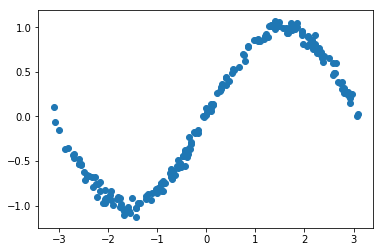

In [61]:
N = 200
xs = np.array(sorted(np.random.uniform(size=N, low=-np.pi, high=np.pi)))
ys = np.sin(xs) + np.random.normal(loc=0, scale=0.05, size=N)
plt.figure()
plt.scatter(xs, ys)

## Implementation
Define simple polynomial curve-fitting via normalization gradient descent in a style inspired by the [Scikit-Learn](https://scikit-learn.org) API. Note: Without normalization, this is not numerically stable.

In [102]:
class Normalizer:
    """SKLearn-style normalizer normalizing values to [-1, 1]"""
    def fit(self, xs):
        self.mean = np.mean(xs)
        self.width = np.max(xs) - np.min(xs)
    def transform(self, xs):
        return (xs - self.mean) / self.width

    
class PolynomialRegression:
    """SKLearn-style polynomial regression function"""
    def __init__(self, degree=3, alpha=0.01, epochs=100):
        self.degree = degree
        self.alpha = alpha
        self.epochs = epochs
    
    def fit(self, xs, ys):
        coeffs = np.random.normal(0, 0.01, size=self.degree + 1)
        for i in range(self.epochs):
            yhats = infer(xs, coeffs)
            err = (yhats-ys).reshape(-1, 1)
            exponents=np.arange(0, len(coeffs)).reshape(1, -1)
            powers = np.power(xs.reshape(-1, 1), exponents)
            dcoeffs = -self.alpha * np.mean(np.multiply(powers, err), axis=0)
            coeffs += dcoeffs
        self.coeffs = coeffs
        return coeffs

    def predict(self, xs):
        return np.polynomial.polynomial.polyval(xs, self.coeffs)

def plot_result(xs, ys, normalizer, predictor, what_we_are_showing):
    """Plot a result"""
    plt.figure()
    xs_display = np.linspace(xs.min(), xs.max(), N)
    xhats_display = normalizer.transform(xs_display)
    yhats = predictor.predict(xhats_display)
    plt.scatter(xs, ys, label="data")
    plt.plot(xs_display, yhats, label="prediction")
    plt.title("Curve fit using {} points of training data\nPredictions for {}"
                  .format(len(xs), what_we_are_showing))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    

Helper function for running an experiment.

In [103]:
def train_on(xs, ys, degree=3, n=N):
    """Run an experiment of fitting a polynomial of degree degree to n data points"""
    if n == N:
        train_indices = np.arange(N)
    else:
        train_indices = sorted(np.random.choice(N, n))
    xs_train = np.take(xs, train_indices)
    ys_train = np.take(ys, train_indices)
    normalizer = Normalizer()
    normalizer.fit(xs_train)
    xhats_train = normalizer.transform(xs_train)
    p = PolynomialRegression(degree=degree, alpha=1.0, epochs=20000)
    coeffs = p.fit(xhats_train, ys_train)
    plot_result(xs_train, ys_train, normalizer, p, "training data")
    
    if n == N:
        plot_result(xs, ys, normalizer, p, "all data")
    else:
        xs_test = np.delete(xs, train_indices)
        ys_test = np.delete(ys, train_indices)
        plot_result(xs_test, ys_test, normalizer, p, "test data")

## Experiments

### Underfitting
A polynomial of degree less than $3$ cannot fit this part of a sine wave well.

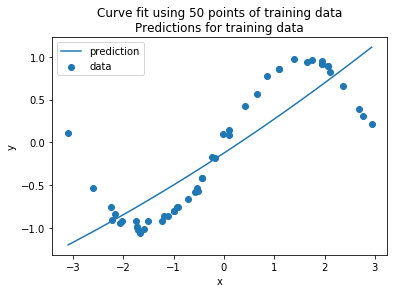

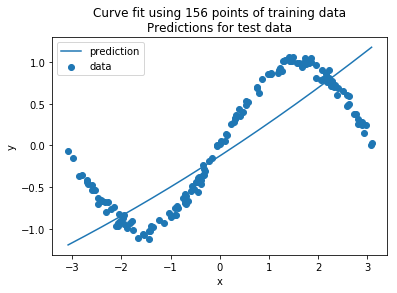

In [125]:
train_on(xs, ys, degree=2, n=50)

### Overfiting
Fitting a high degree polynomial on few points fails more or less spectacularly.

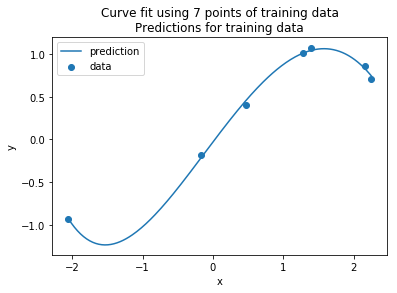

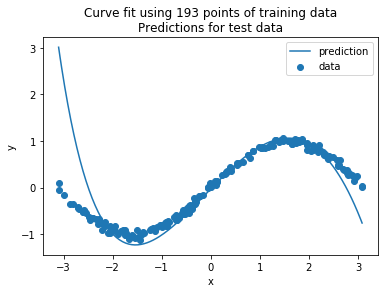

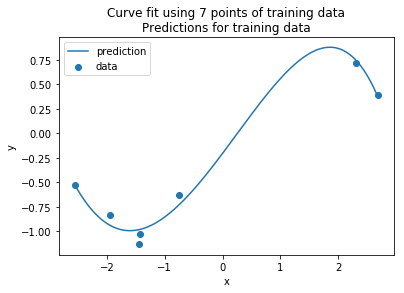

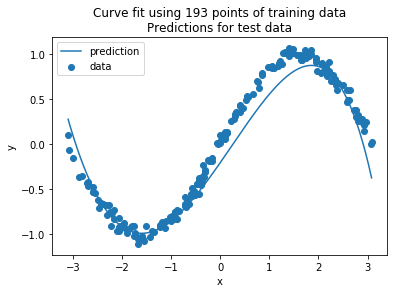

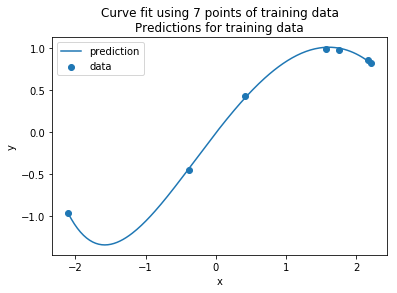

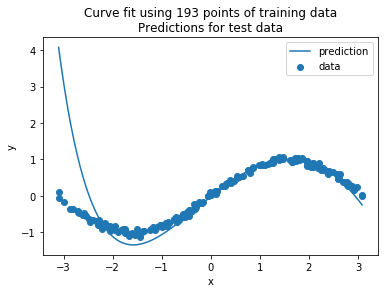

In [122]:
train_on(xs, ys, degree=20, n=7)
train_on(xs, ys, degree=20, n=7)
train_on(xs, ys, degree=20, n=7)

### Avoiding Overfitting by Using a Less Capable Model
Reduce degree, use a bit more data

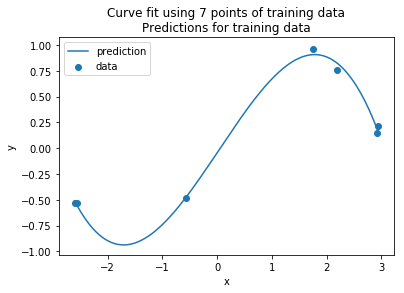

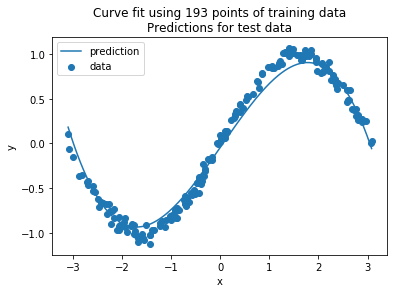

In [123]:
train_on(xs, ys, degree=3, n=7)

# Avoiding Overfitting by Using More Data
Increasing the number of data points deals with overfitting very effectively.

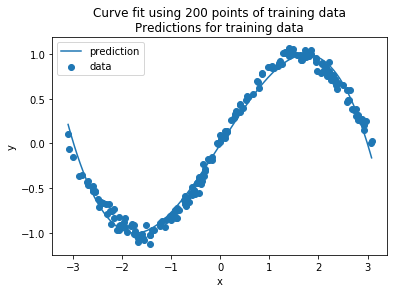

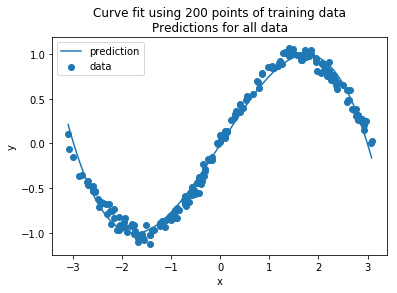

In [124]:
train_on(xs, ys, degree=20, n=200)

## Failure to Generalize
While the method works very well on the training data, it will fail to generalize to parts of the domain it hasn't seen values for. The example in Bishop's book is well-chosen because for every polynomial, there is an interval of the sine wave it cannot fit, due to the fact that the $sin(x)$ is a periodic function, and polynomials are not. If we don't understand the process generating the data, we can easily be fooled into thinking we have a good model because it fits our training data well, and be unpleasantly surprised when it encounters unexpected data when deployed in production.

However, even if a Taylor polynomial of a particular degree could fit the curve, it will not do so unless forced to by training data. Here, I demonstrate this by fitting a polynomial of degree 20 to the interval $[-2\pi, 2\pi)$, and then showing how it looks on $[-2\pi, 2\pi)$. As can be seen [here](https://math.stackexchange.com/questions/9422/an-intuitive-explanation-of-the-taylor-expansion/9444#9444), a the Taylor polynomial of degree 20 would fit the curve on this interval very well. However, a much simpler polynomial suffices to fit the training data, so the model fails to generalize.

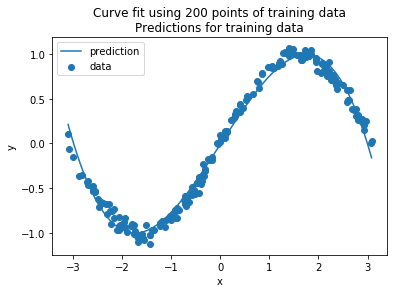

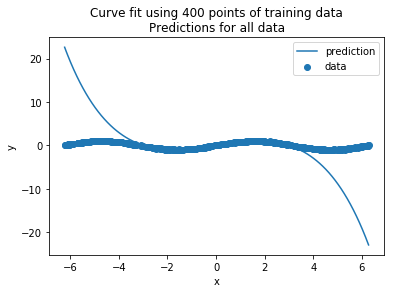

In [133]:
xs_left = np.array(sorted(np.random.uniform(size=int(N/2), low=-2*np.pi, high=-np.pi)))
xs_right = np.array(sorted(np.random.uniform(size=int(N/2), low=np.pi, high=2*np.pi)))
ys_left = np.sin(xs_left) + np.random.normal(loc=0, scale=0.05, size=len(xs_left))
ys_right = np.sin(xs_right) + np.random.normal(loc=0, scale=0.05, size=len(xs_right))
xs_all = np.concatenate([xs_left, xs, xs_right])
ys_all = np.concatenate([ys_left, ys, ys_right])

normalizer = Normalizer()
normalizer.fit(xs)
xhats = normalizer.transform(xs)
p = PolynomialRegression(degree=20, alpha=1.0, epochs=20000)
coeffs = p.fit(xhats, ys)
plot_result(xs, ys, normalizer, p, "training data")
plot_result(xs_all, ys_all, normalizer, p, "all data")

# Learnings
* Normalization is important for numerical stability.
* Vectorizing code is indispensable if you want decent performance. 
* Getting immediate feedback makes experimentation much more fun, so you definitely want your code to have decent performance.
* Scikit-Learn has a wonderful API, and following its design made my code much easier to read.